# Introduction

In this project, we'll work with data from the [CIA World Factbook](https://www.cia.gov/library/publications/the-world-factbook/), a compendium of statistics about all of the countries on Earth. The Factbook contains demographic information like:

 - `population` - The population as of 2015.
 - `population_growth` - The annual population growth rate, as a percentage.
 - `area` - The total land and water area.
 
 In this guided project, we'll explore the Python SQLite workflow to explore, analyze, and visualize data from this database.

## The Data

When working in the Jupyter notebook environment, we can actually use pandas to run SQL queries and display the results neatly as a DataFrame object. We create a `sqlite3.Connection` instance as usual and then use `pandas.read_sql_query(sql, con)` to handle running the query and returning the results in a table:

In [2]:
import sqlite3
import pandas as pd
conn = sqlite3.connect("factbook.db")

#activates the cursor
cursor = conn.cursor()

#the SQL query to look at the tables in the databse
q1 = "SELECT * FROM sqlite_master WHERE type='table';"

#execute the query and read it in pandas, this returns a table in pandas form
database_info = pd.read_sql_query(q1, conn)
database_info

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


We'll look at the first 5 rows:

In [3]:
q2 = "SELECT * FROM facts"

data = pd.read_sql_query(q2, conn)
data.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51
1,2,al,Albania,28748.0,27398.0,1350.0,3029278.0,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741.0,2381741.0,0.0,39542166.0,1.84,23.67,4.31,0.92
3,4,an,Andorra,468.0,468.0,0.0,85580.0,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700.0,1246700.0,0.0,19625353.0,2.78,38.78,11.49,0.46


We can observe that there a number of columns of interest:

 - `name` - The name of the country.
 - `area` - The total land and sea area of the country.
 - `population` - The country's population.
 - `population_growth` - The country's population growth as a percentage.
 - `birth_rate` - The country's birth rate, or the number of births a year per 1,000 people.
 - `death_rate` - The country's death rate, or the number of death a year per 1,000 people.
 - `area` - The country's total area (both land and water).
 - `area_land` - The country's land area in square kilometers.
 - `area_water` - The country's waterarea in square kilometers.

Let's start by calculating some summary statistics and look for any outlier countries.

We'll write a single query that returns the:
 - Minimum population
 - Maximum population
 - Minimum population growth
 - Maximum population growth

In [4]:
q3 = "SELECT MIN(population), MAX(population), MIN(population_growth), MAX(population_growth) FROM facts"
data = pd.read_sql_query(q3, conn)
data.head()

,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


### Observations: 

 - There's a country with a population of 0
 - There's a country with a population of more than 7.2 billion people

We'll examine these countries more closely.



In [5]:
q4 = "SELECT * FROM facts WHERE population == (SELECT MIN(population) from facts);"
data = pd.read_sql_query(q4, conn)
data.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None


In [6]:
q5 = "SELECT * FROM facts WHERE population == (SELECT MAX(population) from facts);"
data = pd.read_sql_query(q5, conn)
data.head()

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


Antarctica and the entire world are outliers which can be exluded from our analysis.
We can write a SQL query along with subqueries to exlude the min and max population from the data and create a histogram. 

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

q6 = '''
SELECT population, population_growth, birth_rate, death_rate
FROM facts
WHERE population != (SELECT MIN(population) from facts)
AND population != (SELECT MAX(population) from facts)
'''

data = pd.read_sql_query(q6, conn)
data.head()

,population,population_growth,birth_rate,death_rate
0,32564342,2.32,38.57,13.89
1,3029278,0.30,12.92,6.58
2,39542166,1.84,23.67,4.31
3,85580,0.12,8.13,6.96
4,19625353,2.78,38.78,11.49


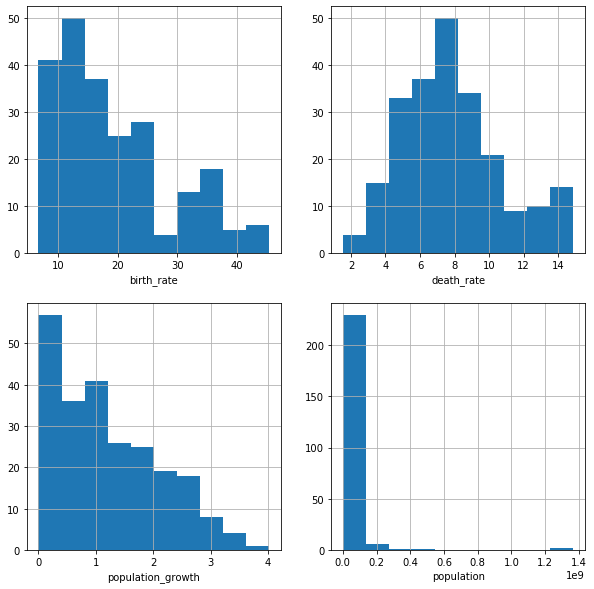

In [8]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

data["birth_rate"].hist(ax=ax1)
ax1.set_xlabel("birth_rate")
data["death_rate"].hist(ax=ax2)
ax2.set_xlabel("death_rate")
data["population_growth"].hist(ax=ax3)
ax3.set_xlabel("population_growth")
data["population"].hist(ax=ax4)
ax4.set_xlabel("population")

plt.show()

### Observations: 

The `birth_rate` and `population` growth plot both show a right-skewed distribution, This makes sense as birth rate and population growth are directly related. The `death_rate` plot shows a normal distribution, almost a double peaked distribution. The population plot is a bit hard to read due to outliers.

## Next we will see what city has the highest population density:

In [13]:
q7 = '''
SELECT name, CAST(population as float)/CAST(area as float) "density"
FROM facts
WHERE population != (SELECT MIN(population) from facts)
AND population != (SELECT MAX(population) from facts)
ORDER BY density DESC
'''

data = pd.read_sql_query(q7, conn)
data.head()

,name,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8141.279770
3,Hong Kong,6445.041516
4,Gaza Strip,5191.819444


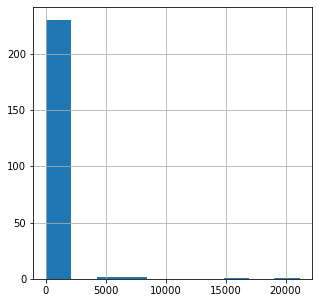

In [10]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

data['density'].hist()

plt.show()

Again there are several outliers making the data hard to read, let's limit the histogram and increase the number of bins.


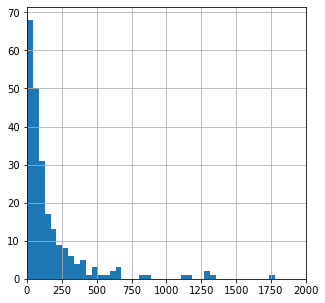

In [11]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

data['density'].hist(bins=500)
ax.set_xlim(0, 2000)
plt.show()

This table includes cities along with countries. Plotting them both together in one histogram doesn't make much sense as cities will obviously have much higher density than countries.
This explains why the population histogram we did earlier showed a similar trend.

## Which countries have the highest ratios of water to land?

In [15]:
q9 = '''select name, 
cast(area_water as float)/cast(area_land as float) 
ratios_of_water_to_land from facts
order by ratios_of_water_to_land desc'''

data = pd.read_sql_query(q9, conn)
data.head()

,name,ratios_of_water_to_land
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231
2,Puerto Rico,0.554791
3,"Bahamas, The",0.386613
4,Guinea-Bissau,0.284673


### Observations:

Here they are counting an Ocean Territory as a country. Islands will obviously have a higer ratio.

## Which countries have more water than land?¶

In [16]:
q10 = '''select name,  cast(area_water as float)/cast(area_land as float) ratios_of_water_to_land from facts
where  ratios_of_water_to_land > 0
order by ratios_of_water_to_land desc
'''


data = pd.read_sql_query(q10, conn)
data.head()

,name,ratios_of_water_to_land
0,British Indian Ocean Territory,905.666667
1,Virgin Islands,4.520231
2,Puerto Rico,0.554791
3,"Bahamas, The",0.386613
4,Guinea-Bissau,0.284673
